<a href="https://colab.research.google.com/github/boomboodo/google-colab/blob/master/Cell_Membrane_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
# import the necessary libraries
import os, cv2, re
import numpy as np
import pandas as pd
import skimage.io as io
import skimage.transform as transform
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import Input, layers, models, optimizers, activations
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, ZeroPadding2D, BatchNormalization, UpSampling2D, concatenate
from keras.models import Sequential, load_model, Model
from keras import backend as K

Using TensorFlow backend.


In [0]:
# create helper functions to sort the image files with numeric values in each file name
def atoi(text):
  return int(text) if text.isdigit() else text

def natural_keys(text):
  return [ atoi(c) for c in re.split('(\d+)', text) ]
  
def prepare_data(list_of_images):
    
  x = []
    
  for image in list_of_images:
    x.append(cv2.resize(cv2.imread(image, 0), (256,256), interpolation=cv2.INTER_CUBIC))
    
  return np.array(x)

In [0]:
train_img_dir = '/gdrive/My Drive/Colab Notebooks/U-Net/data/membrane/train/image/'
train_images = [train_img_dir + i for i in os.listdir(train_img_dir)]
train_images.sort(key = natural_keys)
x_train = prepare_data(train_images)
x_train = x_train.reshape(-1, 256, 256, 1)

train_mask_dir =  '/gdrive/My Drive/Colab Notebooks/U-Net/data/membrane/train/label/'
train_masks = [train_mask_dir + i for i in os.listdir(train_mask_dir)]
train_masks.sort(key = natural_keys)
y_train = prepare_data(train_masks)
y_train = y_train.reshape(-1, 256, 256, 1)

(30, 256, 256, 1)

In [0]:
def my_generator(x_train, y_train, batch_size):
  data_gen_args = dict(rescale = 1. / 255,
                       rotation_range = 0.2,
                       width_shift_range = 0.05,
                       height_shift_range = 0.05,
                       shear_range = 0.05,
                       zoom_range = 0.05,
                       horizontal_flip = True,
                       fill_mode = 'nearest')
  image_datagen = ImageDataGenerator(**data_gen_args).flow(x_train, x_train, batch_size, seed = 1)
  mask_datagen = ImageDataGenerator(**data_gen_args).flow(y_train, y_train, batch_size, seed = 1)

  while True:
    x_batch, _ = image_datagen.next()
    y_batch, _ = mask_datagen.next()
    yield x_batch, y_batch

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [0]:
def unet(pretrained_weights = None, input_size = (256, 256, 1)):
  inputs = Input(input_size)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
  
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
  
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
  
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size = (2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)
  
  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = Model(input = inputs, output = conv10)
  
  
  if(pretrained_weights):
    model.load_weights(pretrained_weights)

  return model

In [8]:
model = unet(pretrained_weights = '/gdrive/My Drive/Colab Notebooks/U-Net/unet_membrane.h5')
model.compile(loss = 'binary_crossentropy', optimizer=optimizers.adam(lr=0.0001), metrics = [dice_coef])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [0]:
model_checkpoint = ModelCheckpoint('/gdrive/My Drive/Colab Notebooks/U-Net/unet_membrane.h5', monitor = 'loss', verbose = 1, save_best_only = True)
model.fit_generator(my_generator(x_train, y_train, 1),
                    steps_per_epoch = 2000,
                    epochs = 10,
                    callbacks = [model_checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
2000/2000 [==============================] - 244s 122ms/step - loss: 0.2796 - dice_coef: 0.8833

Epoch 00001: loss improved from inf to 0.27964, saving model to /gdrive/My Drive/Colab Notebooks/U-Net/unet_membrane.h5
Epoch 2/10
2000/2000 [==============================] - 241s 121ms/step - loss: 0.1858 - dice_coef: 0.9244

Epoch 00002: loss improved from 0.27964 to 0.18582, saving model to /gdrive/My Drive/Colab Notebooks/U-Net/unet_membrane.h5
Epoch 3/10
2000/2000 [==============================] - 241s 121ms/step - loss: 0.1563 - dice_coef: 0.9370

Epoch 00003: loss improved from 0.18582 to 0.15628, saving model to /gdrive/My Drive/Colab Notebooks/U-Net/unet_membrane.h5
Epoch 4/10
2000/2000 [==============================] - 241s 121ms/step - loss: 0.1418 - dice_coef: 0.9430

Epoch 00004: loss improved from 0.15628 to 0.14184, saving model to /gdrive/My Drive/Colab Notebooks/U-Net/unet_membrane.h5
Epoch 5/10
2000/2000 [======

In [0]:
test_img_dir = '/gdrive/My Drive/Colab Notebooks/U-Net/data/membrane/test/original/'
test_images = [test_img_dir + i for i in os.listdir(test_img_dir)]
test_images.sort(key = natural_keys)
x_test = prepare_data(test_images)
x_test = x_test.reshape(-1, 256, 256, 1)

In [0]:
test_mask_dir =  '/gdrive/My Drive/Colab Notebooks/U-Net/data/membrane/test/predicted_label_from_git/'
test_masks = [test_mask_dir + i for i in os.listdir(test_mask_dir)]
test_masks.sort(key = natural_keys)
y_test = prepare_data(test_masks)

In [0]:
results = model.predict(x_test)

In [0]:
for i in range(len(results)):
  cv2.imwrite('/gdrive/My Drive/Colab Notebooks/U-Net/data/membrane/test/predicted/my_{}_predict.png'.format(i), results[i])

In [0]:
pred_mask_dir =  '/gdrive/My Drive/Colab Notebooks/U-Net/data/membrane/test/predicted/'
pred_masks = [pred_mask_dir + i for i in os.listdir(pred_mask_dir)]
pred_masks.sort(key = natural_keys)
y_pred = prepare_data(pred_masks)

In [71]:
print(pred_masks)
print(test_masks)

['/gdrive/My Drive/Colab Notebooks/U-Net/data/membrane/test/predicted/my_0_predict.png', '/gdrive/My Drive/Colab Notebooks/U-Net/data/membrane/test/predicted/my_1_predict.png', '/gdrive/My Drive/Colab Notebooks/U-Net/data/membrane/test/predicted/my_2_predict.png', '/gdrive/My Drive/Colab Notebooks/U-Net/data/membrane/test/predicted/my_3_predict.png', '/gdrive/My Drive/Colab Notebooks/U-Net/data/membrane/test/predicted/my_4_predict.png', '/gdrive/My Drive/Colab Notebooks/U-Net/data/membrane/test/predicted/my_5_predict.png', '/gdrive/My Drive/Colab Notebooks/U-Net/data/membrane/test/predicted/my_6_predict.png', '/gdrive/My Drive/Colab Notebooks/U-Net/data/membrane/test/predicted/my_7_predict.png', '/gdrive/My Drive/Colab Notebooks/U-Net/data/membrane/test/predicted/my_8_predict.png', '/gdrive/My Drive/Colab Notebooks/U-Net/data/membrane/test/predicted/my_9_predict.png', '/gdrive/My Drive/Colab Notebooks/U-Net/data/membrane/test/predicted/my_10_predict.png', '/gdrive/My Drive/Colab Notebo

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


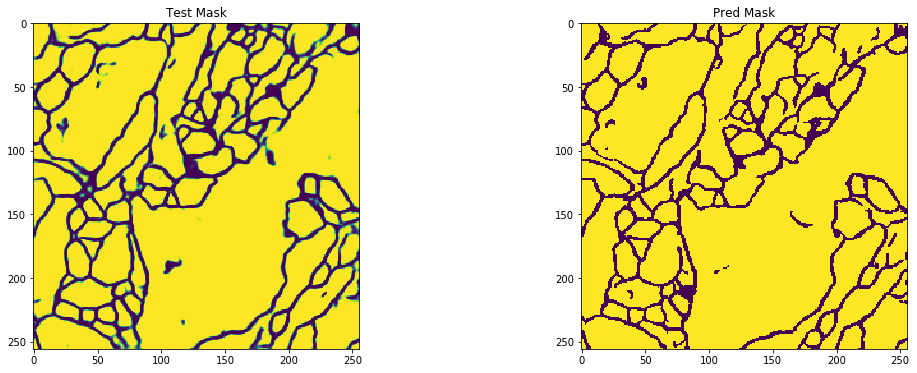

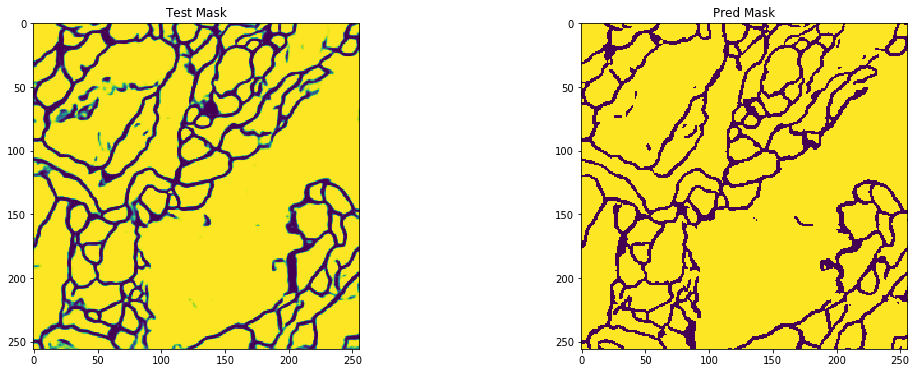

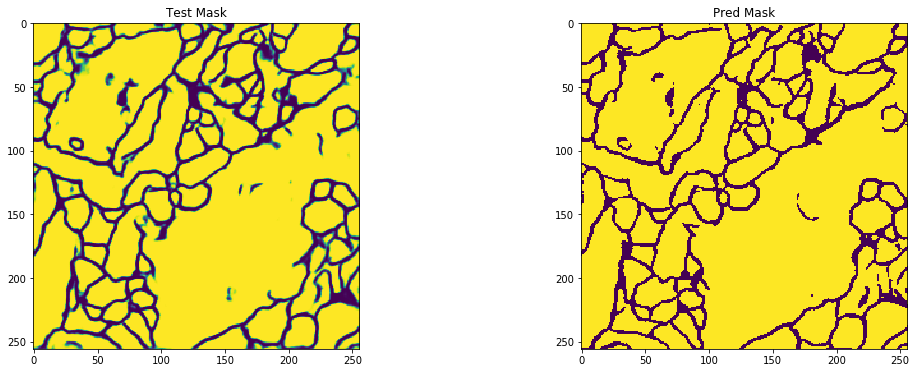

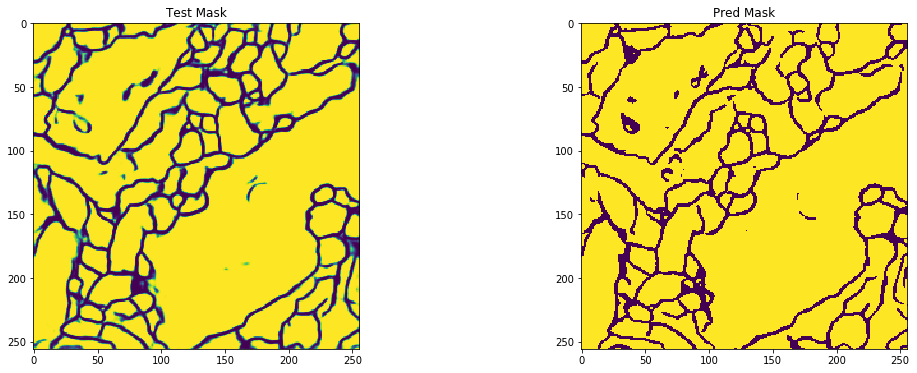

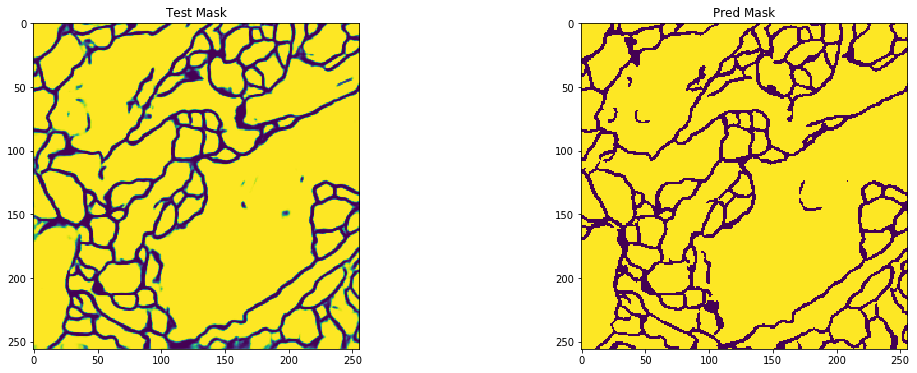

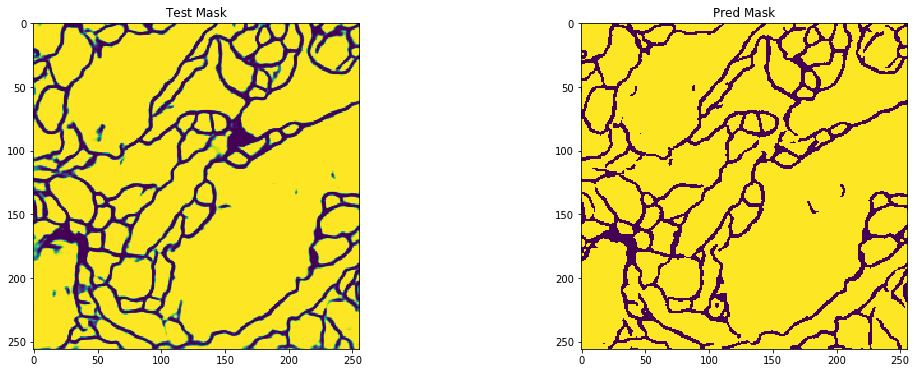

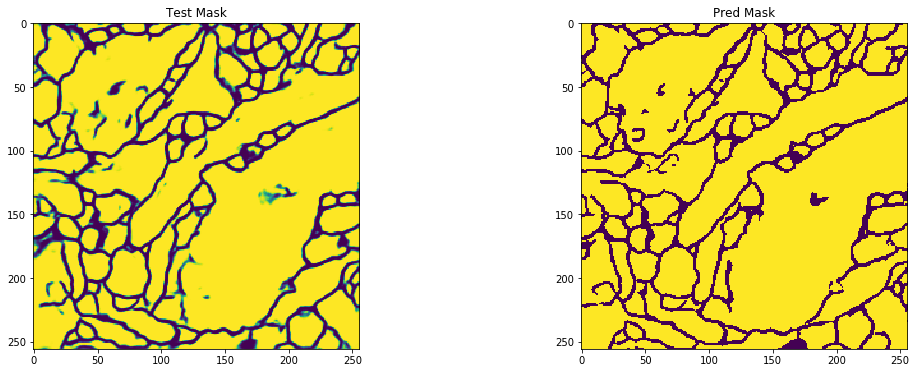

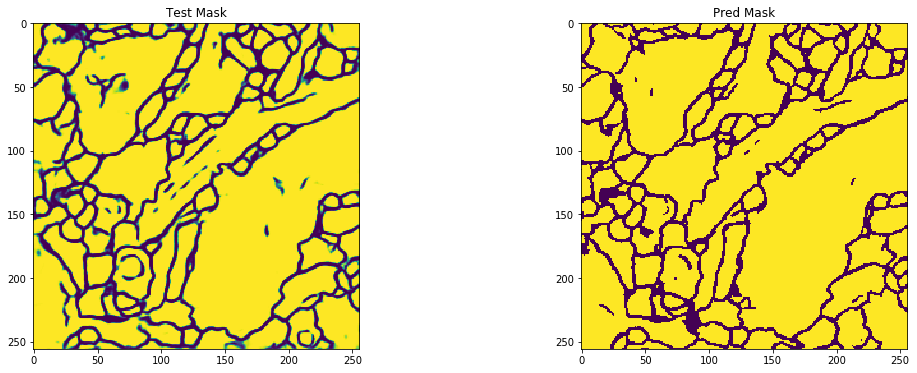

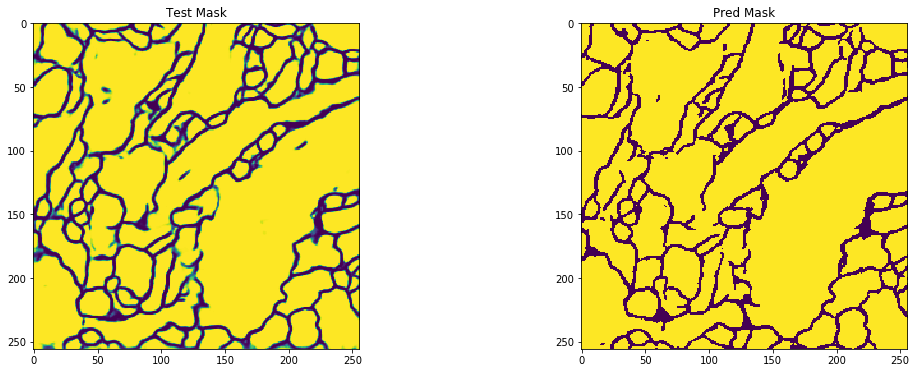

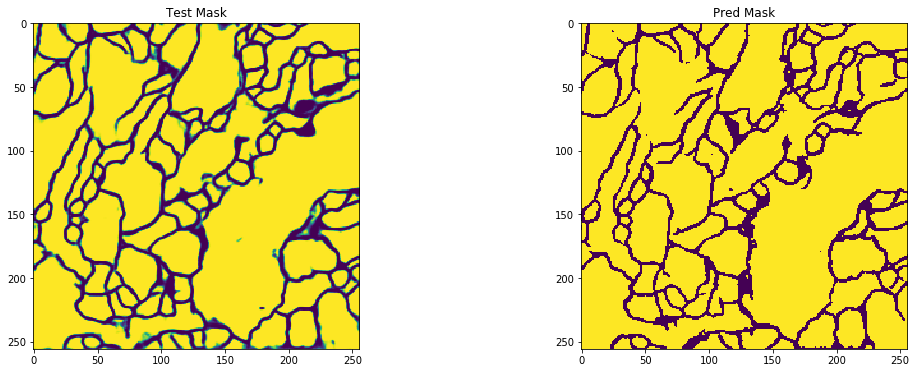

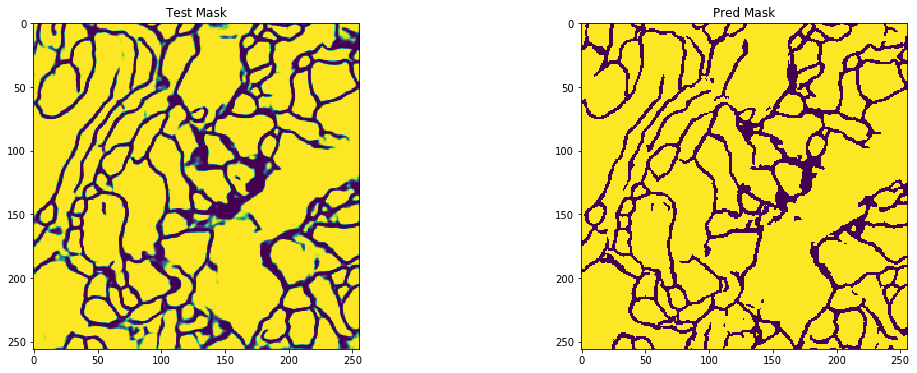

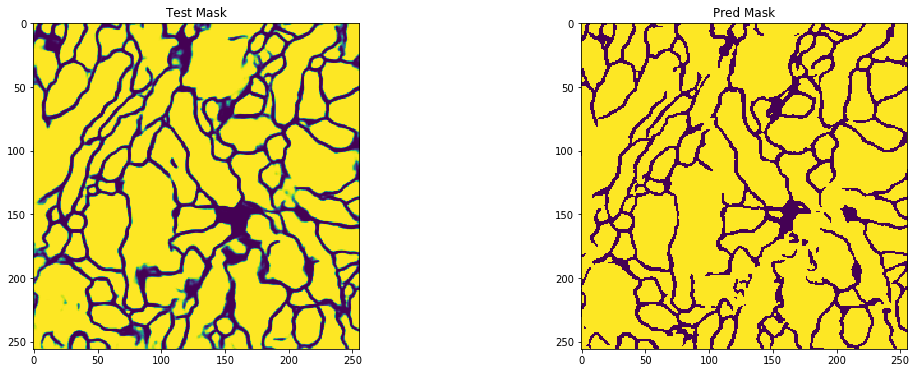

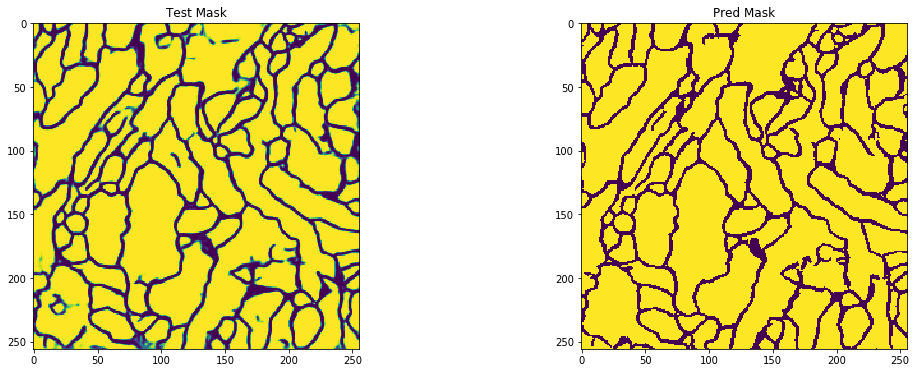

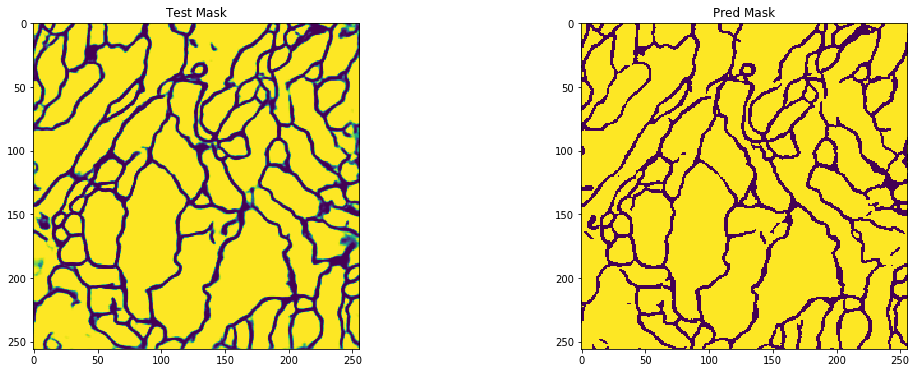

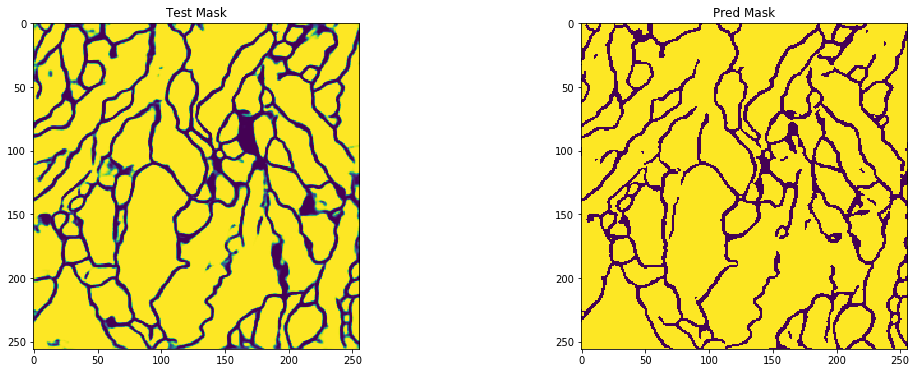

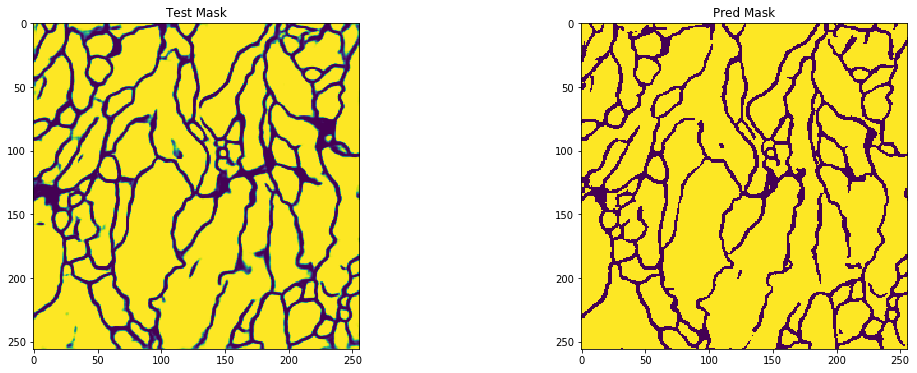

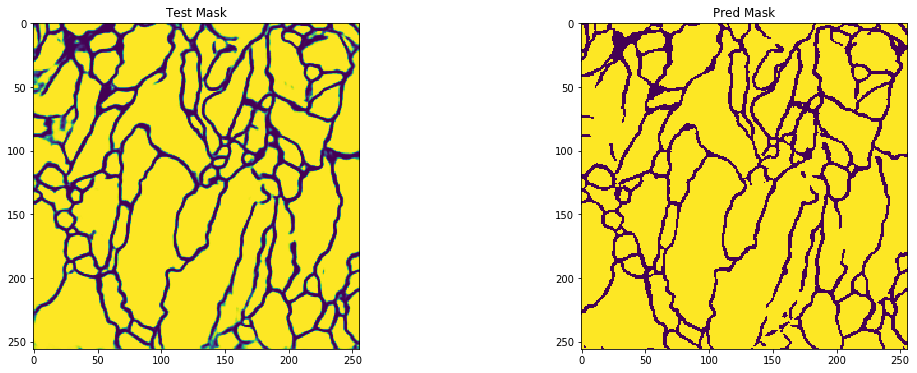

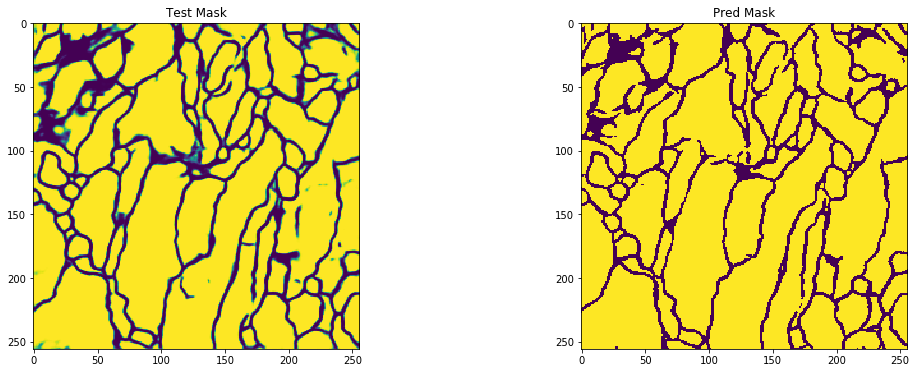

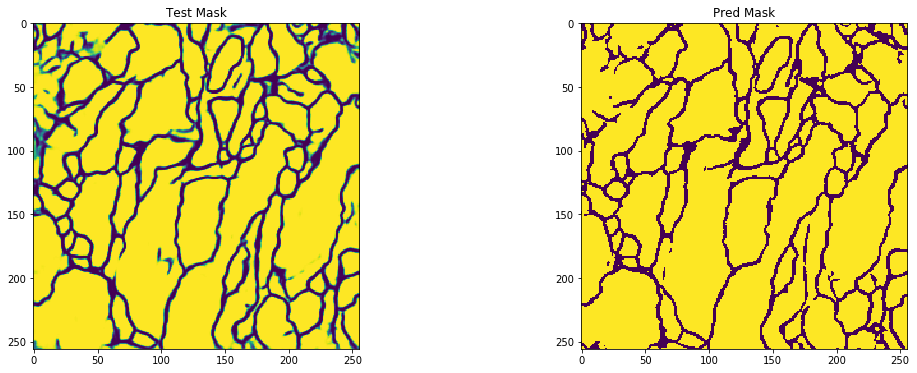

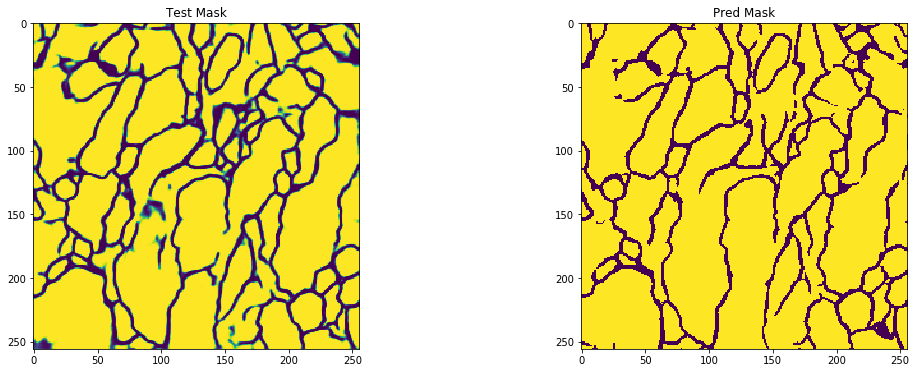

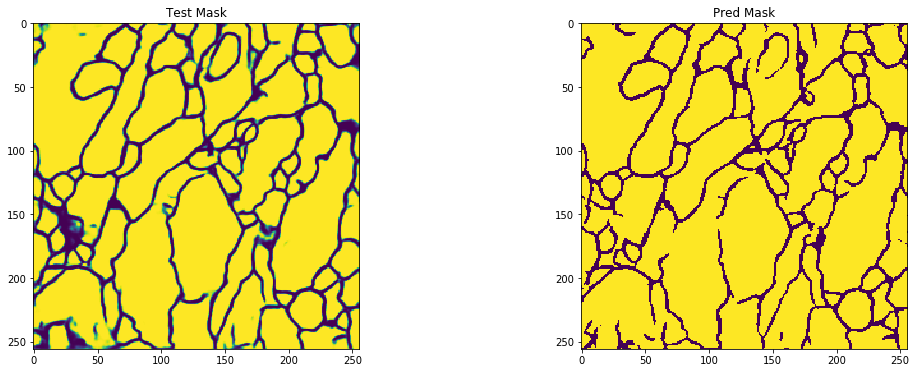

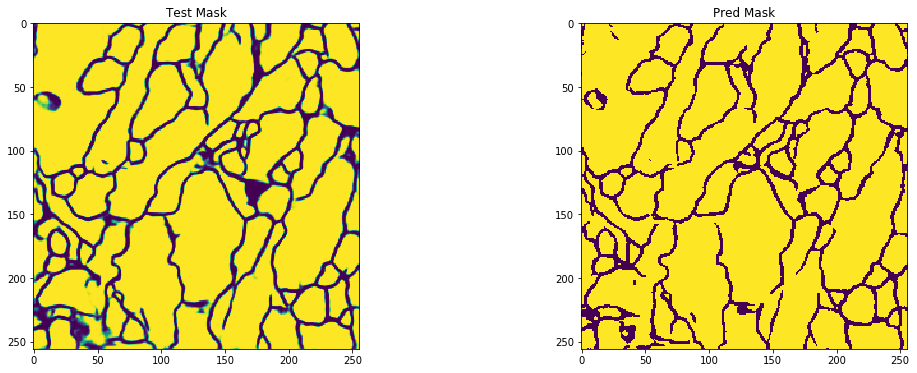

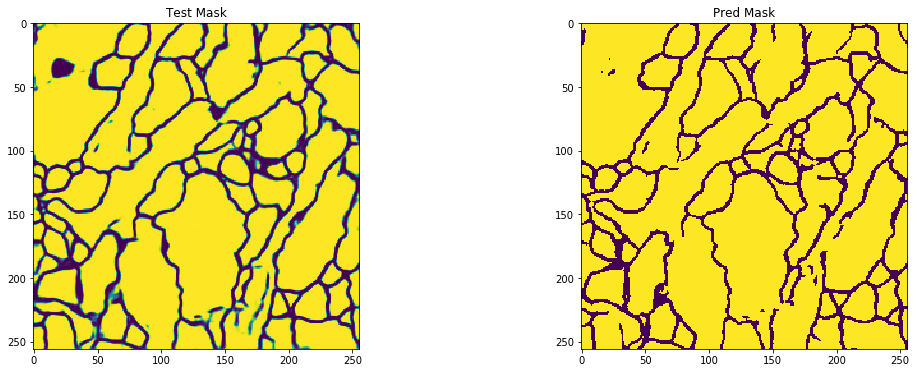

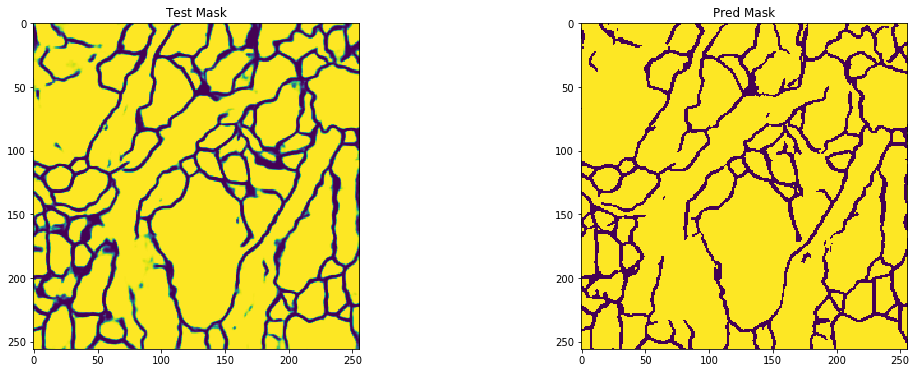

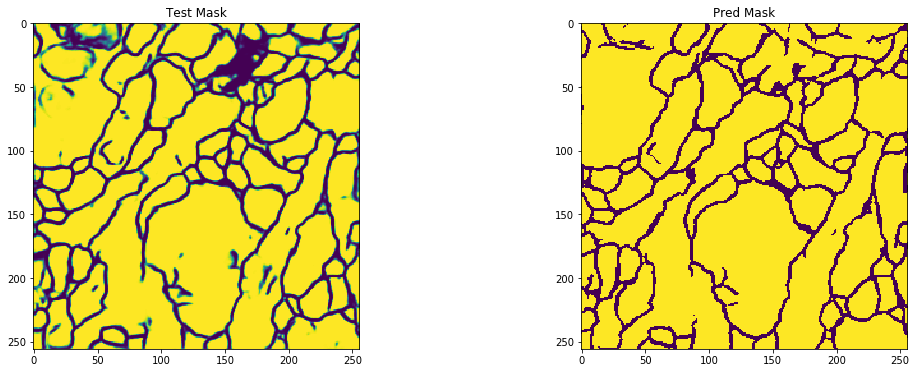

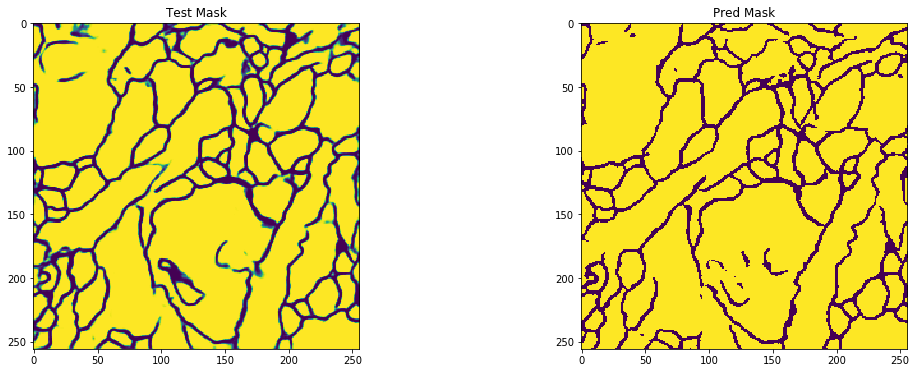

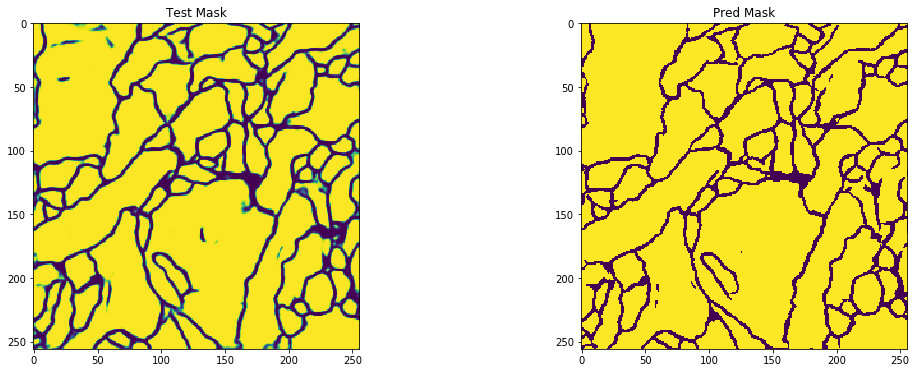

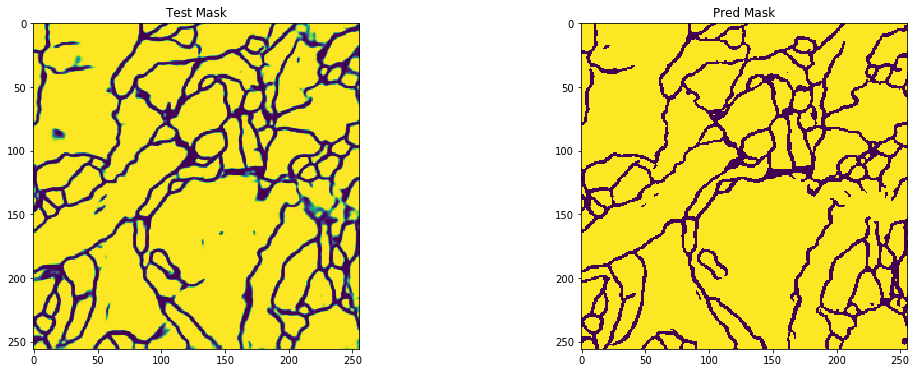

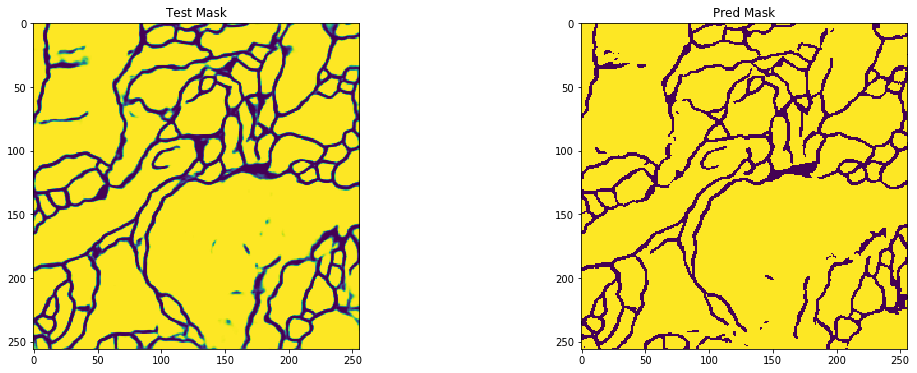

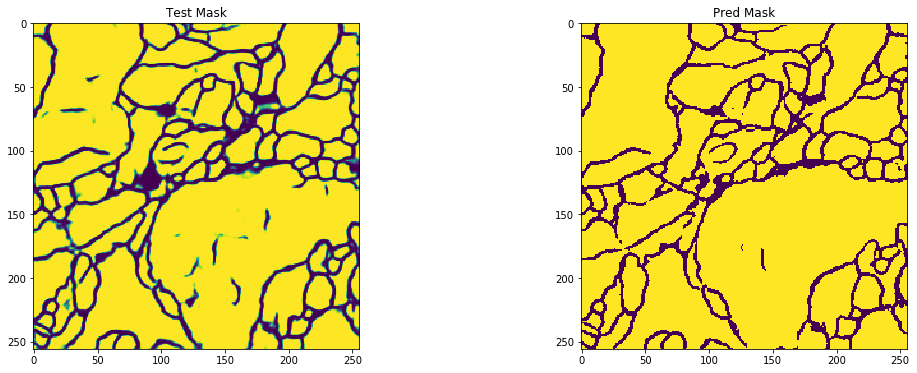

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (18, 6)
for i in range(len(y_pred)):
  f, ax = plt.subplots(1, 2)
  ax[0].set_title('Test Mask')
  ax[0].imshow(y_test[i])
  ax[1].set_title('Pred Mask')
  ax[1].imshow(y_pred[i])